In [328]:
import matplotlib.pyplot as plt
import numpy as np # this module is useful to work with numerical arrays
import pandas as pd # this module is useful to work with tabular data
import random # this module will be used to select random samples from a collection
import os # this module will be used just to create directories in the local filesystem
from tqdm import tqdm # this module is useful to plot progress bars
import plotly.io as pio

import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader,random_split
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.manifold import TSNE
import plotly.express as px
from kmeans_pytorch import kmeans
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

# Step 0 : Preparation

## 0-1 Load Dataset & show sample

In [329]:
data_dir = 'dataset'
### With these commands the train and test datasets, respectively, are downloaded
### automatically and stored in the local "data_dir" directory.
train_dataset = torchvision.datasets.MNIST(data_dir, train=True, download=True)
test_dataset  = torchvision.datasets.MNIST(data_dir, train=False, download=True)

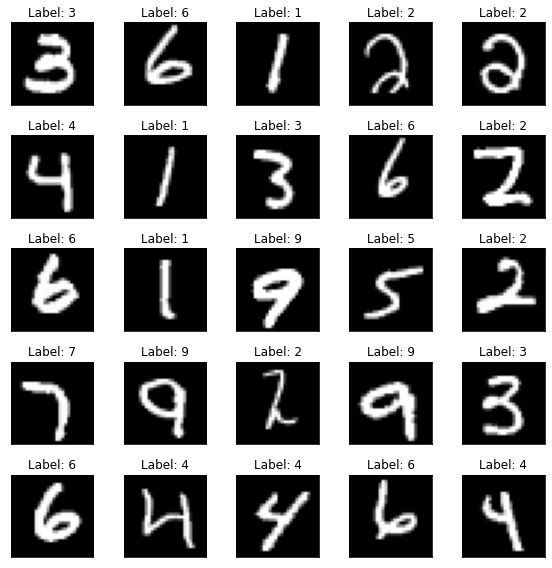

In [330]:
fig, axs = plt.subplots(5, 5, figsize=(8,8))
for ax in axs.flatten():
    # random.choice allows to randomly sample from a list-like object (basically anything that can be accessed with an index, like our dataset)
    img, label = random.choice(train_dataset)
    ax.imshow(np.array(img), cmap='gist_gray')
    ax.set_title('Label: %d' % label)
    ax.set_xticks([])
    ax.set_yticks([])
plt.tight_layout()

## 0-2 Split the data into train, validation, and test

In [331]:
train_transform = transforms.Compose([
    transforms.ToTensor(),
])
test_transform = transforms.Compose([
    transforms.ToTensor(),
])

# Set the train transform
train_dataset.transform = train_transform
# Set the test transform
test_dataset.transform = test_transform

In [332]:
m=len(train_dataset)

#random_split randomly split a dataset into non-overlapping new datasets of given lengths
#train (55,000 images), val split (5,000 images)
train_data, val_data = random_split(train_dataset, [int(m-m*0.2), int(m*0.2)])

batch_size=256

# The dataloaders handle shuffling, batching, etc...
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size)
valid_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,shuffle=True)

In [333]:
print("training:%d"%len(train_data))
print("Validation:%d"%len(val_data))
print("testing:%d"%len(test_dataset))

training:48000
Validation:12000
testing:10000


## 0-3 Establish baseline of K-Mean

In [334]:
num_clusters=10
n_clusters=10

In [335]:
import seaborn as sn
import numpy as np
import matplotlib.pyplot as plt

def print_results(title,c, y):
    y_train_to_clustered  = np.dstack([y, c])[0]
    clustered_tallies = np.zeros((n_clusters, n_clusters), dtype=int)
    for i in range(0, len(y_train_to_clustered)):
        clustered_tallies[y_train_to_clustered[i][1]][y_train_to_clustered[i][0]] += 1

    cluster_to_num_map = list(map(lambda x: np.argmax(x), clustered_tallies))
    clustered_tallies = sorted(clustered_tallies, key=lambda e: np.argmax(e)) 

    fig, ax = plt.subplots(1, figsize=(15,15))
    p = sn.heatmap(clustered_tallies, annot=True, fmt="d", annot_kws={"size": 10}, cmap='coolwarm', ax=ax, square=True, yticklabels=cluster_to_num_map)
    plt.xlabel('Grand-Truth', fontsize=18)
    plt.ylabel('K-Mean', fontsize=18)
    p.tick_params(length=0)
    p.xaxis.tick_top()
    p.xaxis.set_label_position('top')
    
        
    # purity - sum of correct in each class divided by the total number of images
    purity_sums = np.zeros((10, 1))

    for i in range(0, len(y_train_to_clustered[:])):
        if cluster_to_num_map[y_train_to_clustered[i][1]] == y[i]:
            purity_sums[cluster_to_num_map[y_train_to_clustered[i][0]]] += 1
    purity =np.add.reduce(purity_sums)[0] / len(y)
    
    plt.title(title+" Accuracy="+str(purity), fontsize= 20)
    

In [336]:
temp=test_dataset.data.reshape(test_dataset.data.shape[0],-1)
temp.shape

torch.Size([10000, 784])

In [337]:
cluster_ids_x, cluster_centers = kmeans(
    X=temp, num_clusters=num_clusters, distance='euclidean')

running k-means on cpu..


[running kmeans]: 48it [00:08,  5.77it/s, center_shift=0.000000, iteration=48, tol=0.000100]      


In [338]:
#confusion_matrix(test_dataset.targets, cluster_ids_x.numpy())
#accuracy_score(test_dataset.targets, cluster_ids_x.numpy())

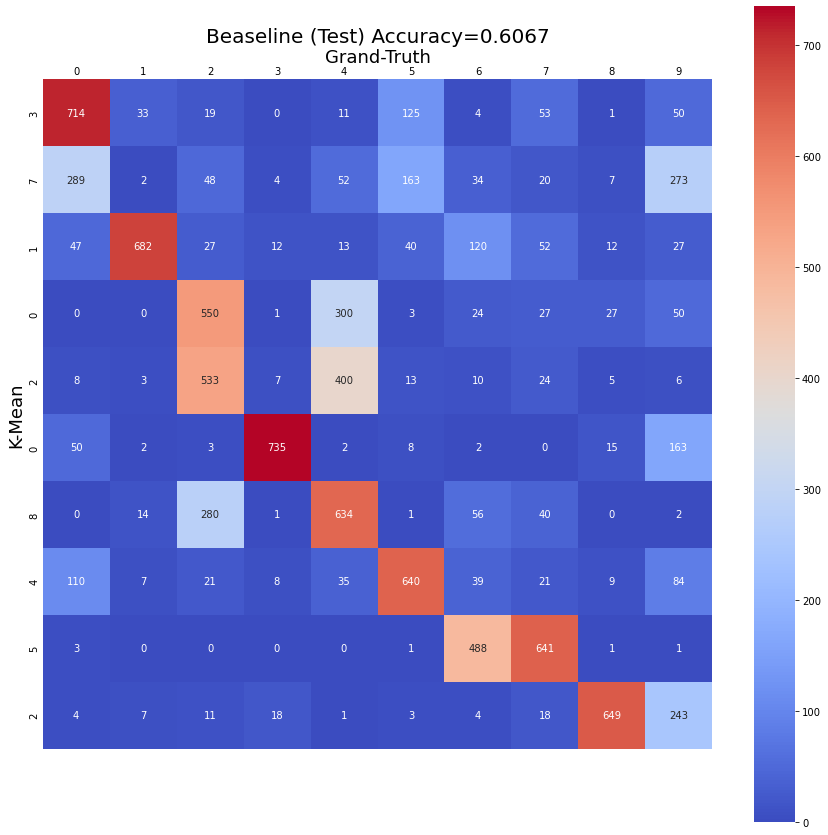

In [339]:
print_results("Beaseline (Test)",test_dataset.targets, cluster_ids_x.numpy())

# Step 1: Define Encoder and Decoder classes

##  1-1 Configurations 

In [428]:
# Add random (gaussion) noise or not 
With_Random_Noise = True
# Size of encoding layer
#d = 2 
d = 16
#d = 256

## 1-2 Construct Encoder

In [429]:
class Encoder_cnn(nn.Module):
    
    def __init__(self, encoded_space_dim,fc2_input_dim):
        super().__init__()
        
        ### Convolutional section
        self.encoder_cnn = nn.Sequential(
            # First convolutional layer
            nn.Conv2d(1, 8, 3, stride=2, padding=1),
            #nn.BatchNorm2d(8),
            nn.ReLU(True),
            # Second convolutional layer
            nn.Conv2d(8, 16, 3, stride=2, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            # Third convolutional layer
            nn.Conv2d(16, 32, 3, stride=2, padding=0),
            #nn.BatchNorm2d(32),
            nn.ReLU(True)
        )
        
        ### Flatten layer
        self.flatten = nn.Flatten(start_dim=1)

        ### Linear section
        self.encoder_lin = nn.Sequential(
            # First linear layer
            nn.Linear(3 * 3 * 32, 128),
            nn.ReLU(True),
            # Second linear layer
            nn.Linear(128, encoded_space_dim)
        )
        
    def forward(self, x):
        # Apply convolutions
        x = self.encoder_cnn(x)
        # Flatten
        x = self.flatten(x)
        # # Apply linear layers
        x = self.encoder_lin(x)
        return x

## 1-3 Construct Decoder 

In [430]:
class Decoder_cnn(nn.Module):
    
    def __init__(self, encoded_space_dim,fc2_input_dim):
        super().__init__()

        ### Linear section
        self.decoder_lin = nn.Sequential(
            # First linear layer
            nn.Linear(encoded_space_dim, 128),
            nn.ReLU(True),
            # Second linear layer
            nn.Linear(128, 3 * 3 * 32),
            nn.ReLU(True)
        )

        ### Unflatten
        self.unflatten = nn.Unflatten(dim=1, unflattened_size=(32, 3, 3))

        ### Convolutional section
        self.decoder_conv = nn.Sequential(
            # First transposed convolution
            nn.ConvTranspose2d(32, 16, 3, stride=2, output_padding=0),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            # Second transposed convolution
            nn.ConvTranspose2d(16, 8, 3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(True),
            # Third transposed convolution
            nn.ConvTranspose2d(8, 1, 3, stride=2, padding=1, output_padding=1)
        )
        
    def forward(self, x):
        # Apply linear layers
        x = self.decoder_lin(x)
        # Unflatten
        x = self.unflatten(x)
        # Apply transposed convolutions
        x = self.decoder_conv(x)
        # Apply a sigmoid to force the output to be between 0 and 1 (valid pixel values)
        x = torch.sigmoid(x)
        return x

# Step 2: initialize models, loss and optimizer

In [431]:
### Set the random seed for reproducible results
torch.manual_seed(0)

### Initialize the two networks 

encoder = Encoder_cnn(encoded_space_dim=d,fc2_input_dim=128)
decoder = Decoder_cnn(encoded_space_dim=d,fc2_input_dim=128)

In [432]:
### Define the loss function
#loss_fn = torch.nn.MSELoss()
loss_fn=torch.nn.L1Loss()

### Define an optimizer (both for the encoder and the decoder!)
lr= 0.001 # Learning rate


params_to_optimize = [
    {'params': encoder.parameters()},
    {'params': decoder.parameters()}
]

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')

optim = torch.optim.Adam(params_to_optimize, lr=lr)

# Move both the encoder and the decoder to the selected device
encoder.to(device)
decoder.to(device)
#model.to(device)

Selected device: cpu


Decoder_cnn(
  (decoder_lin): Sequential(
    (0): Linear(in_features=16, out_features=128, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=128, out_features=288, bias=True)
    (3): ReLU(inplace=True)
  )
  (unflatten): Unflatten(dim=1, unflattened_size=(32, 3, 3))
  (decoder_conv): Sequential(
    (0): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(16, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (4): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(8, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  )
)

# Step 3 :Train model

In [433]:
#pip install opencv-python

In [434]:
im = test_dataset[0][0].unsqueeze(0)
a = im + torch.randn_like(im)*0.3
print(a)

tensor([[[[-1.5116e-01,  4.4324e-01, -5.0087e-02,  3.9716e-01, -2.9120e-01,
           -4.0759e-01,  2.4021e-01,  1.7781e-02, -1.9837e-01,  2.7062e-01,
            2.1473e-02, -1.6384e-01,  8.6209e-02,  6.2561e-01,  3.0296e-01,
            9.2567e-02,  1.2439e-01,  1.1665e-01, -2.7629e-01,  7.8166e-01,
            5.0692e-01, -2.8471e-01,  3.9509e-02,  2.1981e-01,  1.9313e-01,
            4.5897e-01,  1.7366e-01, -2.5181e-01],
          [-6.3322e-01, -7.9723e-02, -5.0753e-01,  3.4238e-03,  3.4161e-01,
            3.4572e-01,  4.9555e-01,  2.0385e-01, -3.0402e-01, -1.7944e-01,
           -4.4005e-01,  4.5082e-01, -3.0224e-01, -5.8443e-02, -3.9901e-02,
           -1.0588e-01,  1.9138e-01, -1.2740e-03, -1.4091e-01,  1.8720e-01,
           -7.4695e-01, -3.6181e-01, -8.6784e-02,  4.6631e-01, -6.0433e-02,
            2.7786e-01,  5.4129e-02, -7.8367e-01],
          [-4.9677e-01, -2.3769e-01,  1.4079e-02, -1.3164e-01,  2.7340e-01,
            1.4055e-01,  5.7069e-01, -4.5020e-02, -2.1938e-01,

In [435]:
 test_dataset.data[0].shape

torch.Size([28, 28])

In [436]:
im = test_dataset[0][0].unsqueeze(0)

In [437]:
im

tensor([[[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 

In [438]:
b = torch.clip(a,0.,1.)
print(b)

tensor([[[[0.0000e+00, 4.4324e-01, 0.0000e+00, 3.9716e-01, 0.0000e+00,
           0.0000e+00, 2.4021e-01, 1.7781e-02, 0.0000e+00, 2.7062e-01,
           2.1473e-02, 0.0000e+00, 8.6209e-02, 6.2561e-01, 3.0296e-01,
           9.2567e-02, 1.2439e-01, 1.1665e-01, 0.0000e+00, 7.8166e-01,
           5.0692e-01, 0.0000e+00, 3.9509e-02, 2.1981e-01, 1.9313e-01,
           4.5897e-01, 1.7366e-01, 0.0000e+00],
          [0.0000e+00, 0.0000e+00, 0.0000e+00, 3.4238e-03, 3.4161e-01,
           3.4572e-01, 4.9555e-01, 2.0385e-01, 0.0000e+00, 0.0000e+00,
           0.0000e+00, 4.5082e-01, 0.0000e+00, 0.0000e+00, 0.0000e+00,
           0.0000e+00, 1.9138e-01, 0.0000e+00, 0.0000e+00, 1.8720e-01,
           0.0000e+00, 0.0000e+00, 0.0000e+00, 4.6631e-01, 0.0000e+00,
           2.7786e-01, 5.4129e-02, 0.0000e+00],
          [0.0000e+00, 0.0000e+00, 1.4079e-02, 0.0000e+00, 2.7340e-01,
           1.4055e-01, 5.7069e-01, 0.0000e+00, 0.0000e+00, 0.0000e+00,
           4.8630e-02, 1.0346e-01, 4.2488e-03, 1.176

In [439]:
def add_noise(inputs,noise_factor=0.3):
     noise = inputs+torch.randn_like(inputs)*noise_factor
     noise = torch.clip(noise,0.,1.)
     return noise

In [440]:
### Training function
def train_epoch_den(encoder, decoder, device, dataloader, loss_fn, optimizer,noise_factor=0.3):
    # Set train mode for both the encoder and the decoder
    encoder.train()
    decoder.train()
    train_loss = []
    # Iterate the dataloader (we do not need the label values, this is unsupervised learning)
    for image_batch, _ in dataloader: # with "_" we just ignore the labels (the second element of the dataloader tuple)
        # Move tensor to the proper device
        if With_Random_Noise:
            image_noisy = add_noise(image_batch,noise_factor)
            image_noisy = image_noisy.to(device)    
        # Encode data
            encoded_data = encoder(image_noisy)
        else:
            encoded_data = encoder(image_batch)
        
        # Decode data
        decoded_data = decoder(encoded_data)
        # Evaluate loss
        #loss = loss_fn(decoded_data, image_noisy)
        loss = loss_fn(decoded_data, image_batch)
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Print batch loss
        print('\t partial train loss (single batch): %f' % (loss.data))
        train_loss.append(loss.detach().cpu().numpy())

    return np.mean(train_loss)

In [441]:
### Testing function
def test_epoch_den(encoder, decoder, device, dataloader, loss_fn,noise_factor=0.3):
    # Set evaluation mode for encoder and decoder
    encoder.eval()
    decoder.eval()
    with torch.no_grad(): # No need to track the gradients
        # Define the lists to store the outputs for each batch
        conc_out = []
        conc_label = []
        for image_batch, _ in dataloader:
            # Move tensor to the proper device
            if With_Random_Noise:
                image_noisy = add_noise(image_batch,noise_factor)
                image_noisy = image_noisy.to(device)
                # Encode data
                encoded_data = encoder(image_noisy)
            else:
                encoded_data = encoder(image_batch)
                
            # Decode data
            decoded_data = decoder(encoded_data)
            # Append the network output and the original image to the lists
            conc_out.append(decoded_data.cpu())
            conc_label.append(image_batch.cpu())
        # Create a single tensor with all the values in the lists
        conc_out = torch.cat(conc_out)
        conc_label = torch.cat(conc_label) 
        # Evaluate global loss
        val_loss = loss_fn(conc_out, conc_label)
    return val_loss.data

In [442]:
def plot_ae_outputs_den(encoder,decoder,n=5,With_Random_Noise=False,noise_factor=0.3):
    plt.figure(figsize=(10,4.5))
    for i in range(n):
        ax = plt.subplot(3,n,i+1)
        img = test_dataset[i][0].unsqueeze(0)
        
        if With_Random_Noise :
            image_noisy = add_noise(img,noise_factor)
            image_noisy = image_noisy.to(device)
        else:
            image_noisy = img
            
        encoder.eval()
        decoder.eval()
        
        with torch.no_grad():
            rec_img  = decoder(encoder(image_noisy))
            
        plt.imshow(img.cpu().squeeze().numpy(), cmap='gist_gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)  
        
        if i == n//2:
            ax.set_title('Original images')
            
        ax = plt.subplot(3, n, i + 1 + n)
        plt.imshow(image_noisy.cpu().squeeze().numpy(), cmap='gist_gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)  
        
        if i == n//2:
            ax.set_title('Corrupted images')
            
        ax = plt.subplot(3, n, i + 1 + n + n)
        plt.imshow(rec_img.cpu().squeeze().numpy(), cmap='gist_gray')  
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)  
        
        if i == n//2:
            ax.set_title('Reconstructed images')
        plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.7, 
                    top=0.9, 
                    wspace=0.3, 
                    hspace=0.3)     
    plt.show()

In [443]:
### Training cycle
noise_factor = 0.3
num_epochs = 30
history_da={'train_loss':[],'val_loss':[]}

for epoch in range(num_epochs):
    print('EPOCH %d/%d' % (epoch + 1, num_epochs))
    ### Training (use the training function)
    train_loss=train_epoch_den(
        encoder=encoder, 
        decoder=decoder, 
        device=device, 
        dataloader=train_loader, 
        loss_fn=loss_fn, 
        optimizer=optim,noise_factor=noise_factor)
    ### Validation  (use the testing function)
    val_loss = test_epoch_den(
        encoder=encoder, 
        decoder=decoder, 
        device=device, 
        dataloader=valid_loader, 
        loss_fn=loss_fn,noise_factor=noise_factor)
    # Print Validationloss
    history_da['train_loss'].append(train_loss)
    history_da['val_loss'].append(val_loss)
    print('\n EPOCH {}/{} \t train loss {:.3f} \t val loss {:.3f}'.format(epoch + 1, num_epochs,train_loss,val_loss))
    #plot_ae_outputs_den(encoder,decoder,With_Random_Noise,noise_factor=noise_factor)

EPOCH 1/30
	 partial train loss (single batch): 0.446990
	 partial train loss (single batch): 0.439085
	 partial train loss (single batch): 0.433668
	 partial train loss (single batch): 0.429313
	 partial train loss (single batch): 0.424889
	 partial train loss (single batch): 0.422183
	 partial train loss (single batch): 0.418721
	 partial train loss (single batch): 0.416005
	 partial train loss (single batch): 0.414007
	 partial train loss (single batch): 0.410940
	 partial train loss (single batch): 0.407320
	 partial train loss (single batch): 0.405946
	 partial train loss (single batch): 0.403316
	 partial train loss (single batch): 0.401045
	 partial train loss (single batch): 0.398628
	 partial train loss (single batch): 0.397102
	 partial train loss (single batch): 0.394701
	 partial train loss (single batch): 0.392495
	 partial train loss (single batch): 0.390282
	 partial train loss (single batch): 0.388319
	 partial train loss (single batch): 0.386598
	 partial train loss (s

	 partial train loss (single batch): 0.167803
	 partial train loss (single batch): 0.167986
	 partial train loss (single batch): 0.166980
	 partial train loss (single batch): 0.165722
	 partial train loss (single batch): 0.165975
	 partial train loss (single batch): 0.164005
	 partial train loss (single batch): 0.164456
	 partial train loss (single batch): 0.163862
	 partial train loss (single batch): 0.160294

 EPOCH 1/30 	 train loss 0.270 	 val loss 0.159
EPOCH 2/30
	 partial train loss (single batch): 0.162480
	 partial train loss (single batch): 0.160573
	 partial train loss (single batch): 0.159713
	 partial train loss (single batch): 0.159057
	 partial train loss (single batch): 0.159571
	 partial train loss (single batch): 0.158738
	 partial train loss (single batch): 0.160339
	 partial train loss (single batch): 0.159300
	 partial train loss (single batch): 0.157999
	 partial train loss (single batch): 0.157209
	 partial train loss (single batch): 0.154934
	 partial train loss

	 partial train loss (single batch): 0.110935
	 partial train loss (single batch): 0.109195
	 partial train loss (single batch): 0.112117
	 partial train loss (single batch): 0.110165
	 partial train loss (single batch): 0.112278
	 partial train loss (single batch): 0.111165
	 partial train loss (single batch): 0.108122
	 partial train loss (single batch): 0.110982
	 partial train loss (single batch): 0.108329
	 partial train loss (single batch): 0.111807
	 partial train loss (single batch): 0.109711
	 partial train loss (single batch): 0.109484
	 partial train loss (single batch): 0.110789
	 partial train loss (single batch): 0.109937
	 partial train loss (single batch): 0.108811
	 partial train loss (single batch): 0.109315
	 partial train loss (single batch): 0.108260
	 partial train loss (single batch): 0.109354
	 partial train loss (single batch): 0.108359
	 partial train loss (single batch): 0.104910

 EPOCH 2/30 	 train loss 0.128 	 val loss 0.107
EPOCH 3/30
	 partial train loss

	 partial train loss (single batch): 0.096048
	 partial train loss (single batch): 0.093479
	 partial train loss (single batch): 0.096066
	 partial train loss (single batch): 0.093930
	 partial train loss (single batch): 0.092272
	 partial train loss (single batch): 0.094168
	 partial train loss (single batch): 0.093849
	 partial train loss (single batch): 0.093625
	 partial train loss (single batch): 0.094007
	 partial train loss (single batch): 0.096162
	 partial train loss (single batch): 0.095704
	 partial train loss (single batch): 0.095127
	 partial train loss (single batch): 0.093244
	 partial train loss (single batch): 0.096704
	 partial train loss (single batch): 0.094287
	 partial train loss (single batch): 0.097182
	 partial train loss (single batch): 0.095759
	 partial train loss (single batch): 0.092572
	 partial train loss (single batch): 0.095601
	 partial train loss (single batch): 0.092705
	 partial train loss (single batch): 0.097057
	 partial train loss (single batch

	 partial train loss (single batch): 0.090196
	 partial train loss (single batch): 0.088657
	 partial train loss (single batch): 0.087479
	 partial train loss (single batch): 0.089397
	 partial train loss (single batch): 0.086801
	 partial train loss (single batch): 0.088755
	 partial train loss (single batch): 0.088665
	 partial train loss (single batch): 0.089196
	 partial train loss (single batch): 0.087139
	 partial train loss (single batch): 0.089210
	 partial train loss (single batch): 0.086426
	 partial train loss (single batch): 0.089208
	 partial train loss (single batch): 0.087236
	 partial train loss (single batch): 0.085267
	 partial train loss (single batch): 0.087415
	 partial train loss (single batch): 0.086952
	 partial train loss (single batch): 0.086822
	 partial train loss (single batch): 0.087154
	 partial train loss (single batch): 0.089270
	 partial train loss (single batch): 0.089291
	 partial train loss (single batch): 0.088528
	 partial train loss (single batch

	 partial train loss (single batch): 0.083959
	 partial train loss (single batch): 0.085480
	 partial train loss (single batch): 0.083334
	 partial train loss (single batch): 0.081134
	 partial train loss (single batch): 0.083439
	 partial train loss (single batch): 0.085373
	 partial train loss (single batch): 0.080459
	 partial train loss (single batch): 0.084375
	 partial train loss (single batch): 0.083252
	 partial train loss (single batch): 0.081412
	 partial train loss (single batch): 0.081227
	 partial train loss (single batch): 0.085338
	 partial train loss (single batch): 0.083997
	 partial train loss (single batch): 0.082782
	 partial train loss (single batch): 0.084742
	 partial train loss (single batch): 0.082136
	 partial train loss (single batch): 0.083973
	 partial train loss (single batch): 0.083933
	 partial train loss (single batch): 0.084438
	 partial train loss (single batch): 0.082522
	 partial train loss (single batch): 0.084483
	 partial train loss (single batch

	 partial train loss (single batch): 0.080420
	 partial train loss (single batch): 0.079467
	 partial train loss (single batch): 0.079717
	 partial train loss (single batch): 0.077396
	 partial train loss (single batch): 0.080270
	 partial train loss (single batch): 0.084359
	 partial train loss (single batch): 0.079088
	 partial train loss (single batch): 0.079108
	 partial train loss (single batch): 0.076260
	 partial train loss (single batch): 0.080366
	 partial train loss (single batch): 0.080021
	 partial train loss (single batch): 0.081735
	 partial train loss (single batch): 0.079423
	 partial train loss (single batch): 0.077329
	 partial train loss (single batch): 0.079627
	 partial train loss (single batch): 0.081309
	 partial train loss (single batch): 0.076783
	 partial train loss (single batch): 0.080424
	 partial train loss (single batch): 0.079595
	 partial train loss (single batch): 0.077588
	 partial train loss (single batch): 0.077566
	 partial train loss (single batch

	 partial train loss (single batch): 0.075459
	 partial train loss (single batch): 0.077540
	 partial train loss (single batch): 0.076612
	 partial train loss (single batch): 0.075016
	 partial train loss (single batch): 0.077672
	 partial train loss (single batch): 0.076511
	 partial train loss (single batch): 0.075558
	 partial train loss (single batch): 0.074627
	 partial train loss (single batch): 0.078092
	 partial train loss (single batch): 0.074753
	 partial train loss (single batch): 0.076012
	 partial train loss (single batch): 0.075233
	 partial train loss (single batch): 0.075421
	 partial train loss (single batch): 0.073416
	 partial train loss (single batch): 0.075976
	 partial train loss (single batch): 0.080104
	 partial train loss (single batch): 0.074546
	 partial train loss (single batch): 0.075003
	 partial train loss (single batch): 0.072130
	 partial train loss (single batch): 0.076029
	 partial train loss (single batch): 0.075682
	 partial train loss (single batch

	 partial train loss (single batch): 0.070499
	 partial train loss (single batch): 0.071195
	 partial train loss (single batch): 0.071376
	 partial train loss (single batch): 0.071514
	 partial train loss (single batch): 0.072599
	 partial train loss (single batch): 0.072090
	 partial train loss (single batch): 0.071951
	 partial train loss (single batch): 0.070718
	 partial train loss (single batch): 0.070289
	 partial train loss (single batch): 0.070497
	 partial train loss (single batch): 0.071048
	 partial train loss (single batch): 0.072866
	 partial train loss (single batch): 0.071916
	 partial train loss (single batch): 0.070195
	 partial train loss (single batch): 0.072722
	 partial train loss (single batch): 0.071763
	 partial train loss (single batch): 0.070872
	 partial train loss (single batch): 0.070005
	 partial train loss (single batch): 0.073432
	 partial train loss (single batch): 0.069913
	 partial train loss (single batch): 0.071479
	 partial train loss (single batch

	 partial train loss (single batch): 0.067187
	 partial train loss (single batch): 0.068843
	 partial train loss (single batch): 0.067470
	 partial train loss (single batch): 0.064712
	 partial train loss (single batch): 0.065753
	 partial train loss (single batch): 0.067310
	 partial train loss (single batch): 0.065180
	 partial train loss (single batch): 0.067902
	 partial train loss (single batch): 0.066514
	 partial train loss (single batch): 0.066257
	 partial train loss (single batch): 0.065589
	 partial train loss (single batch): 0.066413
	 partial train loss (single batch): 0.066578
	 partial train loss (single batch): 0.066668
	 partial train loss (single batch): 0.067515
	 partial train loss (single batch): 0.067235
	 partial train loss (single batch): 0.067115
	 partial train loss (single batch): 0.065702
	 partial train loss (single batch): 0.065478
	 partial train loss (single batch): 0.065704
	 partial train loss (single batch): 0.066049
	 partial train loss (single batch

	 partial train loss (single batch): 0.060577
	 partial train loss (single batch): 0.059417
	 partial train loss (single batch): 0.063092
	 partial train loss (single batch): 0.063813
	 partial train loss (single batch): 0.061612
	 partial train loss (single batch): 0.063580
	 partial train loss (single batch): 0.061788
	 partial train loss (single batch): 0.061993
	 partial train loss (single batch): 0.063638
	 partial train loss (single batch): 0.061415
	 partial train loss (single batch): 0.062718
	 partial train loss (single batch): 0.063895
	 partial train loss (single batch): 0.062804
	 partial train loss (single batch): 0.060525
	 partial train loss (single batch): 0.061081
	 partial train loss (single batch): 0.063149
	 partial train loss (single batch): 0.060775
	 partial train loss (single batch): 0.063138
	 partial train loss (single batch): 0.062196
	 partial train loss (single batch): 0.061533
	 partial train loss (single batch): 0.061181
	 partial train loss (single batch

	 partial train loss (single batch): 0.057887
	 partial train loss (single batch): 0.058429
	 partial train loss (single batch): 0.058744
	 partial train loss (single batch): 0.060825
	 partial train loss (single batch): 0.059453
	 partial train loss (single batch): 0.059129
	 partial train loss (single batch): 0.058184
	 partial train loss (single batch): 0.057774
	 partial train loss (single batch): 0.058500
	 partial train loss (single batch): 0.056517
	 partial train loss (single batch): 0.055304
	 partial train loss (single batch): 0.058805
	 partial train loss (single batch): 0.059833
	 partial train loss (single batch): 0.057565
	 partial train loss (single batch): 0.059105
	 partial train loss (single batch): 0.057894
	 partial train loss (single batch): 0.057615
	 partial train loss (single batch): 0.059281
	 partial train loss (single batch): 0.057473
	 partial train loss (single batch): 0.058234
	 partial train loss (single batch): 0.059063
	 partial train loss (single batch

	 partial train loss (single batch): 0.052949
	 partial train loss (single batch): 0.056650
	 partial train loss (single batch): 0.056824
	 partial train loss (single batch): 0.054726
	 partial train loss (single batch): 0.055156
	 partial train loss (single batch): 0.055717
	 partial train loss (single batch): 0.054744
	 partial train loss (single batch): 0.055280
	 partial train loss (single batch): 0.055533
	 partial train loss (single batch): 0.055455
	 partial train loss (single batch): 0.054390
	 partial train loss (single batch): 0.054932
	 partial train loss (single batch): 0.055288
	 partial train loss (single batch): 0.057599
	 partial train loss (single batch): 0.056125
	 partial train loss (single batch): 0.055426
	 partial train loss (single batch): 0.054455
	 partial train loss (single batch): 0.054224
	 partial train loss (single batch): 0.055491
	 partial train loss (single batch): 0.053400
	 partial train loss (single batch): 0.052123
	 partial train loss (single batch

	 partial train loss (single batch): 0.051965
	 partial train loss (single batch): 0.052172
	 partial train loss (single batch): 0.050876
	 partial train loss (single batch): 0.053996
	 partial train loss (single batch): 0.051304
	 partial train loss (single batch): 0.052980
	 partial train loss (single batch): 0.051355
	 partial train loss (single batch): 0.050951
	 partial train loss (single batch): 0.052679
	 partial train loss (single batch): 0.050374
	 partial train loss (single batch): 0.053253
	 partial train loss (single batch): 0.053568
	 partial train loss (single batch): 0.052085
	 partial train loss (single batch): 0.052267
	 partial train loss (single batch): 0.052558
	 partial train loss (single batch): 0.051524
	 partial train loss (single batch): 0.052538
	 partial train loss (single batch): 0.052529
	 partial train loss (single batch): 0.052127
	 partial train loss (single batch): 0.051909
	 partial train loss (single batch): 0.052338
	 partial train loss (single batch

	 partial train loss (single batch): 0.048888
	 partial train loss (single batch): 0.049533
	 partial train loss (single batch): 0.051651
	 partial train loss (single batch): 0.050359
	 partial train loss (single batch): 0.050687
	 partial train loss (single batch): 0.049012
	 partial train loss (single batch): 0.049641
	 partial train loss (single batch): 0.052309
	 partial train loss (single batch): 0.048490
	 partial train loss (single batch): 0.053948
	 partial train loss (single batch): 0.049329
	 partial train loss (single batch): 0.049517
	 partial train loss (single batch): 0.048438
	 partial train loss (single batch): 0.051432
	 partial train loss (single batch): 0.048754
	 partial train loss (single batch): 0.049842
	 partial train loss (single batch): 0.049004
	 partial train loss (single batch): 0.048533
	 partial train loss (single batch): 0.050129
	 partial train loss (single batch): 0.048086
	 partial train loss (single batch): 0.050544
	 partial train loss (single batch

	 partial train loss (single batch): 0.046418
	 partial train loss (single batch): 0.047586
	 partial train loss (single batch): 0.047387
	 partial train loss (single batch): 0.046527
	 partial train loss (single batch): 0.050083
	 partial train loss (single batch): 0.046338
	 partial train loss (single batch): 0.048335
	 partial train loss (single batch): 0.046389
	 partial train loss (single batch): 0.046075
	 partial train loss (single batch): 0.046269
	 partial train loss (single batch): 0.047882
	 partial train loss (single batch): 0.046353
	 partial train loss (single batch): 0.046760
	 partial train loss (single batch): 0.048888
	 partial train loss (single batch): 0.047984
	 partial train loss (single batch): 0.047663
	 partial train loss (single batch): 0.046212
	 partial train loss (single batch): 0.047151
	 partial train loss (single batch): 0.049158
	 partial train loss (single batch): 0.045593
	 partial train loss (single batch): 0.051241
	 partial train loss (single batch

	 partial train loss (single batch): 0.044250
	 partial train loss (single batch): 0.043836
	 partial train loss (single batch): 0.043642
	 partial train loss (single batch): 0.045833
	 partial train loss (single batch): 0.044019
	 partial train loss (single batch): 0.044101
	 partial train loss (single batch): 0.044685
	 partial train loss (single batch): 0.043165
	 partial train loss (single batch): 0.045692
	 partial train loss (single batch): 0.043935
	 partial train loss (single batch): 0.044024
	 partial train loss (single batch): 0.043543
	 partial train loss (single batch): 0.044613
	 partial train loss (single batch): 0.043732
	 partial train loss (single batch): 0.043366
	 partial train loss (single batch): 0.046582
	 partial train loss (single batch): 0.043238
	 partial train loss (single batch): 0.044862
	 partial train loss (single batch): 0.043436
	 partial train loss (single batch): 0.043081
	 partial train loss (single batch): 0.042776
	 partial train loss (single batch

	 partial train loss (single batch): 0.041575
	 partial train loss (single batch): 0.041099
	 partial train loss (single batch): 0.040393
	 partial train loss (single batch): 0.040006
	 partial train loss (single batch): 0.040802
	 partial train loss (single batch): 0.041305
	 partial train loss (single batch): 0.040515
	 partial train loss (single batch): 0.040152
	 partial train loss (single batch): 0.040131
	 partial train loss (single batch): 0.039059
	 partial train loss (single batch): 0.039993
	 partial train loss (single batch): 0.039469
	 partial train loss (single batch): 0.039668
	 partial train loss (single batch): 0.040814
	 partial train loss (single batch): 0.039721
	 partial train loss (single batch): 0.039761
	 partial train loss (single batch): 0.040490
	 partial train loss (single batch): 0.039316
	 partial train loss (single batch): 0.041555
	 partial train loss (single batch): 0.039308
	 partial train loss (single batch): 0.039733
	 partial train loss (single batch

	 partial train loss (single batch): 0.036956
	 partial train loss (single batch): 0.036068
	 partial train loss (single batch): 0.038194
	 partial train loss (single batch): 0.036532
	 partial train loss (single batch): 0.038090
	 partial train loss (single batch): 0.038054
	 partial train loss (single batch): 0.038234
	 partial train loss (single batch): 0.037752
	 partial train loss (single batch): 0.037961
	 partial train loss (single batch): 0.038265
	 partial train loss (single batch): 0.038282
	 partial train loss (single batch): 0.036929
	 partial train loss (single batch): 0.036850
	 partial train loss (single batch): 0.038088
	 partial train loss (single batch): 0.038390
	 partial train loss (single batch): 0.037561
	 partial train loss (single batch): 0.036855
	 partial train loss (single batch): 0.037483
	 partial train loss (single batch): 0.036573
	 partial train loss (single batch): 0.036836
	 partial train loss (single batch): 0.036417
	 partial train loss (single batch


 EPOCH 18/30 	 train loss 0.037 	 val loss 0.037
EPOCH 19/30
	 partial train loss (single batch): 0.036444
	 partial train loss (single batch): 0.036579
	 partial train loss (single batch): 0.036284
	 partial train loss (single batch): 0.035168
	 partial train loss (single batch): 0.037501
	 partial train loss (single batch): 0.037164
	 partial train loss (single batch): 0.037702
	 partial train loss (single batch): 0.036911
	 partial train loss (single batch): 0.035685
	 partial train loss (single batch): 0.035354
	 partial train loss (single batch): 0.037133
	 partial train loss (single batch): 0.035351
	 partial train loss (single batch): 0.036858
	 partial train loss (single batch): 0.036271
	 partial train loss (single batch): 0.036678
	 partial train loss (single batch): 0.036580
	 partial train loss (single batch): 0.036243
	 partial train loss (single batch): 0.037144
	 partial train loss (single batch): 0.037117
	 partial train loss (single batch): 0.036230
	 partial train lo

	 partial train loss (single batch): 0.036158
	 partial train loss (single batch): 0.036254
	 partial train loss (single batch): 0.036992
	 partial train loss (single batch): 0.036735
	 partial train loss (single batch): 0.034842
	 partial train loss (single batch): 0.034944
	 partial train loss (single batch): 0.035902
	 partial train loss (single batch): 0.036571
	 partial train loss (single batch): 0.035669
	 partial train loss (single batch): 0.034528

 EPOCH 19/30 	 train loss 0.036 	 val loss 0.036
EPOCH 20/30
	 partial train loss (single batch): 0.035789
	 partial train loss (single batch): 0.035932
	 partial train loss (single batch): 0.035069
	 partial train loss (single batch): 0.034338
	 partial train loss (single batch): 0.036530
	 partial train loss (single batch): 0.036230
	 partial train loss (single batch): 0.036560
	 partial train loss (single batch): 0.036139
	 partial train loss (single batch): 0.034600
	 partial train loss (single batch): 0.034580
	 partial train lo

	 partial train loss (single batch): 0.036360
	 partial train loss (single batch): 0.034730
	 partial train loss (single batch): 0.035566
	 partial train loss (single batch): 0.034933
	 partial train loss (single batch): 0.036534
	 partial train loss (single batch): 0.036572
	 partial train loss (single batch): 0.035974
	 partial train loss (single batch): 0.034217
	 partial train loss (single batch): 0.035730
	 partial train loss (single batch): 0.035291
	 partial train loss (single batch): 0.035158
	 partial train loss (single batch): 0.035604
	 partial train loss (single batch): 0.035423
	 partial train loss (single batch): 0.036402
	 partial train loss (single batch): 0.036535
	 partial train loss (single batch): 0.034570
	 partial train loss (single batch): 0.034651
	 partial train loss (single batch): 0.035102
	 partial train loss (single batch): 0.035966
	 partial train loss (single batch): 0.035511
	 partial train loss (single batch): 0.033817

 EPOCH 20/30 	 train loss 0.035 	

	 partial train loss (single batch): 0.034871
	 partial train loss (single batch): 0.033186
	 partial train loss (single batch): 0.035015
	 partial train loss (single batch): 0.034070
	 partial train loss (single batch): 0.033758
	 partial train loss (single batch): 0.034464
	 partial train loss (single batch): 0.034531
	 partial train loss (single batch): 0.034366
	 partial train loss (single batch): 0.033821
	 partial train loss (single batch): 0.036457
	 partial train loss (single batch): 0.035980
	 partial train loss (single batch): 0.034516
	 partial train loss (single batch): 0.035105
	 partial train loss (single batch): 0.034781
	 partial train loss (single batch): 0.035975
	 partial train loss (single batch): 0.036151
	 partial train loss (single batch): 0.035340
	 partial train loss (single batch): 0.033945
	 partial train loss (single batch): 0.035649
	 partial train loss (single batch): 0.034628
	 partial train loss (single batch): 0.035006
	 partial train loss (single batch

	 partial train loss (single batch): 0.033812
	 partial train loss (single batch): 0.034549
	 partial train loss (single batch): 0.033940
	 partial train loss (single batch): 0.035043
	 partial train loss (single batch): 0.035534
	 partial train loss (single batch): 0.034393
	 partial train loss (single batch): 0.034973
	 partial train loss (single batch): 0.034247
	 partial train loss (single batch): 0.034810
	 partial train loss (single batch): 0.033163
	 partial train loss (single batch): 0.034433
	 partial train loss (single batch): 0.032639
	 partial train loss (single batch): 0.034687
	 partial train loss (single batch): 0.033786
	 partial train loss (single batch): 0.033020
	 partial train loss (single batch): 0.033971
	 partial train loss (single batch): 0.034127
	 partial train loss (single batch): 0.033762
	 partial train loss (single batch): 0.033769
	 partial train loss (single batch): 0.036219
	 partial train loss (single batch): 0.035623
	 partial train loss (single batch

	 partial train loss (single batch): 0.035298
	 partial train loss (single batch): 0.034395
	 partial train loss (single batch): 0.033818
	 partial train loss (single batch): 0.032735
	 partial train loss (single batch): 0.035751
	 partial train loss (single batch): 0.032207
	 partial train loss (single batch): 0.033813
	 partial train loss (single batch): 0.034833
	 partial train loss (single batch): 0.033822
	 partial train loss (single batch): 0.033812
	 partial train loss (single batch): 0.034832
	 partial train loss (single batch): 0.034005
	 partial train loss (single batch): 0.034816
	 partial train loss (single batch): 0.035345
	 partial train loss (single batch): 0.034201
	 partial train loss (single batch): 0.034621
	 partial train loss (single batch): 0.034021
	 partial train loss (single batch): 0.034678
	 partial train loss (single batch): 0.033319
	 partial train loss (single batch): 0.034004
	 partial train loss (single batch): 0.032609
	 partial train loss (single batch

	 partial train loss (single batch): 0.033930
	 partial train loss (single batch): 0.032774
	 partial train loss (single batch): 0.034581
	 partial train loss (single batch): 0.035933
	 partial train loss (single batch): 0.033235
	 partial train loss (single batch): 0.033624
	 partial train loss (single batch): 0.032366
	 partial train loss (single batch): 0.033672
	 partial train loss (single batch): 0.035072
	 partial train loss (single batch): 0.035280
	 partial train loss (single batch): 0.033913
	 partial train loss (single batch): 0.033276
	 partial train loss (single batch): 0.032662
	 partial train loss (single batch): 0.035658
	 partial train loss (single batch): 0.032096
	 partial train loss (single batch): 0.033867
	 partial train loss (single batch): 0.034587
	 partial train loss (single batch): 0.033530
	 partial train loss (single batch): 0.033220
	 partial train loss (single batch): 0.034019
	 partial train loss (single batch): 0.033616
	 partial train loss (single batch

	 partial train loss (single batch): 0.033390
	 partial train loss (single batch): 0.032413
	 partial train loss (single batch): 0.033913
	 partial train loss (single batch): 0.034968
	 partial train loss (single batch): 0.033708
	 partial train loss (single batch): 0.034364
	 partial train loss (single batch): 0.034551
	 partial train loss (single batch): 0.032713
	 partial train loss (single batch): 0.032610
	 partial train loss (single batch): 0.033504
	 partial train loss (single batch): 0.034109
	 partial train loss (single batch): 0.032743
	 partial train loss (single batch): 0.034142
	 partial train loss (single batch): 0.035755
	 partial train loss (single batch): 0.033037
	 partial train loss (single batch): 0.033625
	 partial train loss (single batch): 0.032568
	 partial train loss (single batch): 0.033672
	 partial train loss (single batch): 0.034580
	 partial train loss (single batch): 0.034919
	 partial train loss (single batch): 0.033856
	 partial train loss (single batch

	 partial train loss (single batch): 0.034071
	 partial train loss (single batch): 0.033919
	 partial train loss (single batch): 0.032809
	 partial train loss (single batch): 0.033479
	 partial train loss (single batch): 0.034517
	 partial train loss (single batch): 0.033638
	 partial train loss (single batch): 0.033237
	 partial train loss (single batch): 0.033817
	 partial train loss (single batch): 0.033554
	 partial train loss (single batch): 0.033732
	 partial train loss (single batch): 0.034843
	 partial train loss (single batch): 0.033649
	 partial train loss (single batch): 0.032220
	 partial train loss (single batch): 0.033659
	 partial train loss (single batch): 0.034419
	 partial train loss (single batch): 0.033211
	 partial train loss (single batch): 0.033923
	 partial train loss (single batch): 0.034479
	 partial train loss (single batch): 0.032423
	 partial train loss (single batch): 0.032371
	 partial train loss (single batch): 0.033641
	 partial train loss (single batch

	 partial train loss (single batch): 0.032894
	 partial train loss (single batch): 0.033360
	 partial train loss (single batch): 0.033129
	 partial train loss (single batch): 0.032810
	 partial train loss (single batch): 0.034607
	 partial train loss (single batch): 0.032781
	 partial train loss (single batch): 0.033138
	 partial train loss (single batch): 0.033873
	 partial train loss (single batch): 0.033423
	 partial train loss (single batch): 0.033462
	 partial train loss (single batch): 0.034156
	 partial train loss (single batch): 0.033799
	 partial train loss (single batch): 0.032919
	 partial train loss (single batch): 0.033603
	 partial train loss (single batch): 0.034135
	 partial train loss (single batch): 0.033625
	 partial train loss (single batch): 0.033285
	 partial train loss (single batch): 0.033353
	 partial train loss (single batch): 0.033543
	 partial train loss (single batch): 0.033714
	 partial train loss (single batch): 0.034644
	 partial train loss (single batch

	 partial train loss (single batch): 0.034821
	 partial train loss (single batch): 0.033942
	 partial train loss (single batch): 0.033087
	 partial train loss (single batch): 0.033744
	 partial train loss (single batch): 0.032582
	 partial train loss (single batch): 0.032688
	 partial train loss (single batch): 0.034025
	 partial train loss (single batch): 0.032416
	 partial train loss (single batch): 0.033232
	 partial train loss (single batch): 0.033252
	 partial train loss (single batch): 0.033233
	 partial train loss (single batch): 0.032879
	 partial train loss (single batch): 0.032960
	 partial train loss (single batch): 0.034222
	 partial train loss (single batch): 0.032582
	 partial train loss (single batch): 0.033226
	 partial train loss (single batch): 0.033888
	 partial train loss (single batch): 0.033057
	 partial train loss (single batch): 0.032720
	 partial train loss (single batch): 0.033839
	 partial train loss (single batch): 0.033989
	 partial train loss (single batch

	 partial train loss (single batch): 0.032871
	 partial train loss (single batch): 0.032934
	 partial train loss (single batch): 0.034223
	 partial train loss (single batch): 0.034074
	 partial train loss (single batch): 0.032654
	 partial train loss (single batch): 0.032046
	 partial train loss (single batch): 0.034104
	 partial train loss (single batch): 0.033525
	 partial train loss (single batch): 0.033340
	 partial train loss (single batch): 0.031799
	 partial train loss (single batch): 0.034840
	 partial train loss (single batch): 0.033912
	 partial train loss (single batch): 0.032448
	 partial train loss (single batch): 0.033623
	 partial train loss (single batch): 0.032312
	 partial train loss (single batch): 0.032185
	 partial train loss (single batch): 0.034152
	 partial train loss (single batch): 0.032680
	 partial train loss (single batch): 0.033134
	 partial train loss (single batch): 0.032479
	 partial train loss (single batch): 0.032920
	 partial train loss (single batch

	 partial train loss (single batch): 0.032253
	 partial train loss (single batch): 0.033421
	 partial train loss (single batch): 0.034337
	 partial train loss (single batch): 0.032938
	 partial train loss (single batch): 0.032973
	 partial train loss (single batch): 0.033664
	 partial train loss (single batch): 0.032130
	 partial train loss (single batch): 0.032635
	 partial train loss (single batch): 0.033009
	 partial train loss (single batch): 0.033043
	 partial train loss (single batch): 0.033158
	 partial train loss (single batch): 0.032936
	 partial train loss (single batch): 0.033005
	 partial train loss (single batch): 0.034342
	 partial train loss (single batch): 0.034169
	 partial train loss (single batch): 0.032226
	 partial train loss (single batch): 0.031761
	 partial train loss (single batch): 0.033875
	 partial train loss (single batch): 0.033334
	 partial train loss (single batch): 0.033427
	 partial train loss (single batch): 0.031760
	 partial train loss (single batch

In [444]:
test_epoch_den(encoder,decoder,device,test_loader,loss_fn).item()

0.033936757594347

# Step 4: Generate new samples

In [445]:
"""
# works only at d =2 
def plot_reconstructed(decoder, r0=(-5, 10), r1=(-10, 5), n=10):
    plt.figure(figsize=(20,8.5))
    w = 28
    img = np.zeros((n*w, n*w))
    for i, y in enumerate(np.linspace(*r1, n)):
        for j, x in enumerate(np.linspace(*r0, n)):
            z = torch.Tensor([[x, y]]).to(device)
            x_hat = decoder(z)
            x_hat = x_hat.reshape(28, 28).to('cpu').detach().numpy()
            img[(n-1-i)*w:(n-1-i+1)*w, j*w:(j+1)*w] = x_hat
    plt.imshow(img, extent=[*r0, *r1], cmap='gist_gray')
    
plot_reconstructed(decoder, r0=(-1, 1), r1=(-1, 1))
"""

"\n# works only at d =2 \ndef plot_reconstructed(decoder, r0=(-5, 10), r1=(-10, 5), n=10):\n    plt.figure(figsize=(20,8.5))\n    w = 28\n    img = np.zeros((n*w, n*w))\n    for i, y in enumerate(np.linspace(*r1, n)):\n        for j, x in enumerate(np.linspace(*r0, n)):\n            z = torch.Tensor([[x, y]]).to(device)\n            x_hat = decoder(z)\n            x_hat = x_hat.reshape(28, 28).to('cpu').detach().numpy()\n            img[(n-1-i)*w:(n-1-i+1)*w, j*w:(j+1)*w] = x_hat\n    plt.imshow(img, extent=[*r0, *r1], cmap='gist_gray')\n    \nplot_reconstructed(decoder, r0=(-1, 1), r1=(-1, 1))\n"

# Step 5: Visualize latent code

In [446]:
encoded_samples = []
for sample in tqdm(test_dataset):
    img = sample[0].unsqueeze(0).to(device)
    label = sample[1]
    # Encode image
    encoder.eval()
    with torch.no_grad():
        encoded_img  = encoder(img)
    # Append to list
    encoded_img = encoded_img.flatten().cpu().numpy()
    encoded_sample = {f"Enc. Variable {i}": enc for i, enc in enumerate(encoded_img)}
    encoded_sample['label'] = label
    encoded_samples.append(encoded_sample)

100%|██████████████████████████████████████████████████████████████████████████| 10000/10000 [00:05<00:00, 1790.17it/s]


In [447]:
encoded_samples = pd.DataFrame(encoded_samples)
encoded_samples

,Enc. Variable 0,Enc. Variable 1,Enc. Variable 2,Enc. Variable 3,Enc. Variable 4,Enc. Variable 5,Enc. Variable 6,Enc. Variable 7,Enc. Variable 8,Enc. Variable 9,Enc. Variable 10,Enc. Variable 11,Enc. Variable 12,Enc. Variable 13,Enc. Variable 14,Enc. Variable 15,label
0,0.239247,0.031418,1.089174,0.573690,-0.023476,-0.578621,-0.514478,0.637223,-0.089261,-0.082799,-0.153044,-0.439015,0.705171,0.866038,-0.075433,0.355177,7
1,-0.873847,0.279724,-0.745112,-0.952381,-0.465431,-0.696912,0.129019,0.369659,0.019021,0.222330,-0.335058,0.134361,-1.005047,-0.043035,0.301085,0.118739,2
2,-0.742027,-0.409696,0.218109,0.527061,-0.164574,-0.765435,-0.343356,0.696945,-1.288969,0.492420,0.291168,-0.044297,-0.411495,0.488475,-0.457238,-0.209711,1
3,-0.675172,-0.095613,0.690871,-0.402898,-0.145980,-0.264836,0.707880,0.204902,0.783508,-0.620631,-0.326568,-0.608243,0.237147,0.227919,0.032913,-0.060075,0
4,-0.166935,0.306668,0.446176,0.141862,-0.805685,-1.399537,-0.083365,-0.069189,0.301713,-0.394660,-0.876044,0.167693,1.014697,-0.115652,-1.135886,-0.150475,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,-0.876302,0.320616,0.502017,-0.335381,-0.350331,-0.409697,-0.200304,-0.681804,0.078889,0.076548,-0.008697,-0.385397,-0.675590,0.453800,0.104800,-0.795290,2
9996,-0.724494,0.256898,0.572615,-0.515885,0.033735,-0.769983,0.508569,0.347601,0.535769,0.041676,-0.194678,-0.621751,-0.395234,0.549868,1.013491,0.225687,3
9997,-0.626319,0.079772,0.601585,0.511086,-0.554300,-0.306945,-0.276123,0.095062,-0.538710,-0.590734,0.406709,-0.560451,0.678584,-0.064412,-0.561003,0.265817,4
9998,0.473112,0.103517,-0.351625,-0.020292,-0.116695,-0.669246,-0.088962,1.147746,-0.074256,-0.709335,0.324706,-1.053554,0.044413,0.145941,0.113099,0.369337,5


In [448]:
px.scatter(encoded_samples, x='Enc. Variable 0', y='Enc. Variable 1', color=encoded_samples.label.astype(str), opacity=0.7)

In [393]:
tsne = TSNE(n_components=2)
tsne_results = tsne.fit_transform(encoded_samples.drop(['label'],axis=1))

In [394]:
fig = px.scatter(tsne_results, x=0, y=1, color=encoded_samples.label.astype(str),labels={'0': 'tsne-2d-one', '1': 'tsne-2d-two'})
fig.show()

# Step 6:  Evaluate performance of K-Mean

In [449]:
encoded_sample=encoded_samples.drop(['label'],axis=1)
k_mean_sample=torch.tensor(encoded_sample.values)
cluster_ids_x, cluster_centers = kmeans(
    X=k_mean_sample, num_clusters=num_clusters, distance='euclidean')

running k-means on cpu..


[running kmeans]: 56it [00:00, 91.00it/s, center_shift=0.000082, iteration=56, tol=0.000100]


In [450]:
k_mean_sample.shape

torch.Size([10000, 16])

In [451]:
confusion_matrix(encoded_samples['label'], cluster_ids_x.numpy())

array([[  1,   2, 785,  94,   3,  33,   1,   5,   0,  56],
       [  1,   0,   0,   0, 418,   4,   2,   4, 706,   0],
       [ 14,   6,  40,  19,  25,  18, 813,  70,  14,  13],
       [ 12,  12,   4, 111,   2,   1,  34, 113,  27, 694],
       [509, 333,   0,  18,  85,  15,   5,   0,  17,   0],
       [ 16,  32,   4, 370,  39,   5,   4, 138,   5, 279],
       [  5,   2,  26,  79,  14, 797,   2,  12,  20,   1],
       [223, 600,   1,  12, 155,   0,   5,   0,  32,   0],
       [ 12,  28,   9, 320,  29,   7,   4, 513,   6,  46],
       [445, 451,   7,  39,  33,   4,   1,   9,  13,   7]], dtype=int64)

In [452]:
accuracy_score(encoded_samples['label'], cluster_ids_x.numpy())

0.0257

In [453]:
title=""
if With_Random_Noise:
    title+="With_Random_Noise"
else:
    title+="No_Random_Noise"
   
title = title + " Encoder-Dim=" + str(d)+"  "

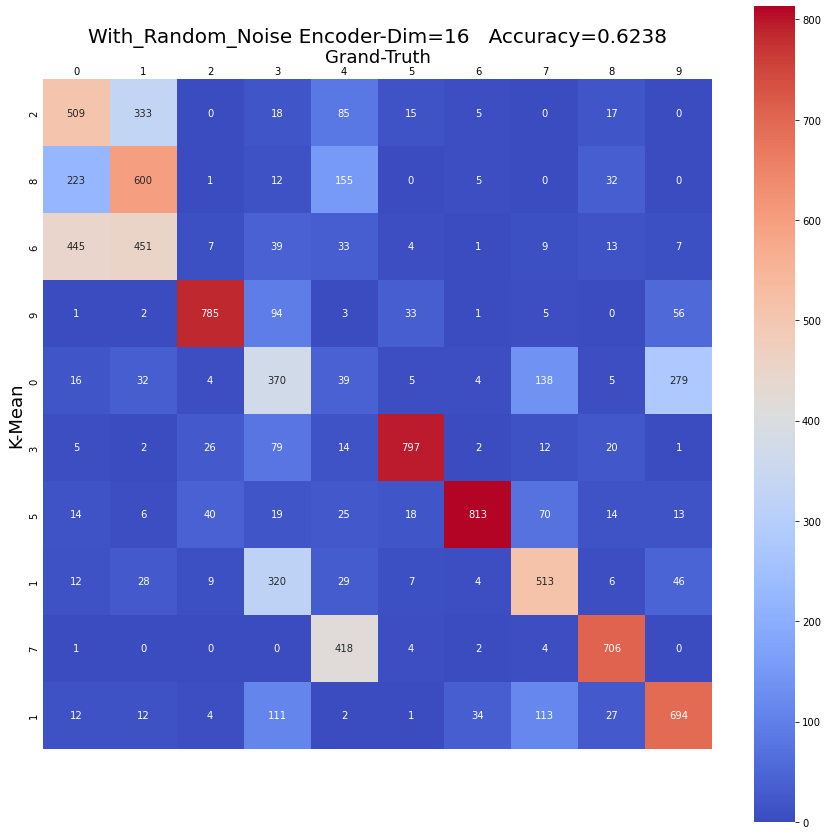

In [454]:
print_results(title,encoded_samples['label'], cluster_ids_x.numpy())